# **DBScan Clustering - CMPT 459 Course Project**

This notebook performs **Density-based clustering** on the diabetic patient dataset.

We do the following:
- Data preprocessing consistent with the project pipeline
- PCA for dimensionality reduction for visualization of results
- 2D/3D PCA visualization of best clustering 
- Custom implemention of **density-based clustering** ( `dbscan_clustering.py`)
- Silhouette score as a metric to evaluate cluster quality

This notebook is part of our group’s modular report and references:
- `dbscan_clustering.py`
- `dbscan_clustering_analysis.py` (original script version)


In [ ]:
import sys
import os

# Find project root by looking for 'data' directory
def find_project_root():
    """Find project root by looking for 'data' directory."""
    current = os.path.abspath(os.getcwd())
    while current != os.path.dirname(current):  # Stop at filesystem root
        if os.path.exists(os.path.join(current, 'data', 'diabetic_data.csv')):
            return current
        current = os.path.dirname(current)
    # Fallback: assume we're in project root or one level down
    if os.path.exists('data/diabetic_data.csv'):
        return os.getcwd()
    elif os.path.exists('../data/diabetic_data.csv'):
        return os.path.dirname(os.getcwd())
    else:
        raise FileNotFoundError("Could not find project root. Please ensure 'data/diabetic_data.csv' exists.")

# Set project root
PROJECT_ROOT = find_project_root()
sys.path.insert(0, PROJECT_ROOT)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from dbscan_clustering import DBScan

print(f"Project root: {PROJECT_ROOT}")
print(f"Data file exists: {os.path.exists(os.path.join(PROJECT_ROOT, 'data', 'diabetic_data.csv'))}")

##  Loading and Preprocessing Data 

Following the same loading and preprocessing data process as the rest of the project, we apply the following:

- Replace `'?'` values with `NaN`  
- Drop columns with >40% missing values 
- One-hot encode high-cardinality categorical columns  
- Label-encode low-cardinality categorical features  
- Normalize numerical features  
- Encode our target variable `readmitted` as integers:  
  - `NO → 0`, `>30 → 1`, `<30 → 2`  
- Remove sensitive/identifying data: `encounter_id`, `patient_nbr`

Finally, we sample **1,000** rows (default) to allow DBScan to run in a reasonable amount of time as the algorithm runs in worst case **O(n^2)**.

In [3]:
def load_and_preprocess_data(path):
    print("Loading data...")
    df = pd.read_csv(path)
    print(f"Original shape: {df.shape}")

    # Replace '?'
    df = df.replace('?', np.nan)

    # Drop >40% missing
    threshold = 0.4 * len(df)
    df = df.dropna(thresh=threshold, axis=1)

    # Fill remaining categorical NA
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].fillna("Unknown")

    # Encode target
    df["readmitted"] = df["readmitted"].map({'NO':0, '>30':1, '<30':2})

    # Encode categorical
    cat_cols = df.select_dtypes(include='object').columns
    le = LabelEncoder()
    for col in cat_cols:
        if df[col].nunique() < 10:
            df[col] = le.fit_transform(df[col].astype(str))
        else:
            df = pd.get_dummies(df, columns=[col], drop_first=True)

    # Remove ID columns
    for col in ["encounter_id", "patient_nbr"]:
        if col in df.columns:
            df = df.drop(columns=[col])

    # Normalize numeric
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    print("Preprocessing complete!")
    print("Final shape:", df.shape)

    target = df["readmitted"].copy()
    X = df.drop(columns=["readmitted"]).values

    return X, target

## Representative Subset Sampling
We will take a representative sample subset (default: 1000) of the diabetic dataset as DBScan scales quadratically with sample size.

In [6]:
# Use absolute path to data file
# Ensure PROJECT_ROOT is defined (re-run cell 1 if needed)
if 'PROJECT_ROOT' not in globals():
    # Re-define find_project_root if needed
    def find_project_root():
        current = os.path.abspath(os.getcwd())
        while current != os.path.dirname(current):
            if os.path.exists(os.path.join(current, 'data', 'diabetic_data.csv')):
                return current
            current = os.path.dirname(current)
        if os.path.exists('data/diabetic_data.csv'):
            return os.getcwd()
        elif os.path.exists('../data/diabetic_data.csv'):
            return os.path.dirname(os.getcwd())
        else:
            raise FileNotFoundError("Could not find project root.")
    PROJECT_ROOT = find_project_root()
    
data_path = os.path.join(PROJECT_ROOT, "data", "diabetic_data.csv")
X, target = load_and_preprocess_data(data_path)
sample_size = 1000
np.random.seed(42)

if len(X) > sample_size:
        print(f"Sampling {sample_size} points for DBScan...")
        idx = np.random.choice(len(X), sample_size, replace = False)
        X = X[idx]
        target = target.iloc[idx].values
else:
    target = target.values

X.shape 

Loading data...
Original shape: (101766, 50)
Preprocessing complete!
Final shape: (101766, 2390)
Sampling 1000 points for DBScan...


(1000, 2389)

## PCA Dimensionality Reduction 

We reduce dimensionality to **50 principal components**, preserving ~85–90% variance.  We use PCA to reduce dimensionality of the dataset to **50 principal components**, preserving ~85-90% variance. Doing so allows us to speed up the clustering algorithm and avoid complications with higher dimension non-linearity. 

In [7]:
n_components = 50 
pca = PCA(n_components)
X_pca = pca.fit_transform(X)

print("PCA shape:", X_pca.shape)
print("PCA done running. Explained variance:", np.sum(pca.explained_variance_ratio_))

PCA shape: (1000, 50)
PCA done running. Explained variance: 0.9270094663631537


##  Finding Appropriate Epsilon Using k-Distance Graph

DBScan requires choosing an appropriate epsilon (ε) value. We use the **k-distance graph** method to find suitable epsilon values:
- For each point, find the distance to its k-th nearest neighbor (k = minPts)
- Sort these distances
- Look for the "elbow" in the sorted k-distance graph
- Use percentiles to suggest epsilon values

We then test multiple epsilon values and select the one with the best silhouette score.

*Silhouette score measures the well-separateness of clusters, with higher = better with a max of 1.0.*


In [8]:
# Find appropriate epsilon using k-distance graph
print("Finding appropriate epsilon using k-distance graph...")
minPts = 5
neighbors = NearestNeighbors(n_neighbors=minPts)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)

# Sort distances to k-th nearest neighbor
k_distances = np.sort(distances[:, minPts-1])

# Use percentiles to suggest epsilon values
eps_25 = np.percentile(k_distances, 25)
eps_50 = np.percentile(k_distances, 50)
eps_75 = np.percentile(k_distances, 75)
eps_90 = np.percentile(k_distances, 90)

print(f"k-distance statistics (k={minPts}):")
print(f"  25th percentile: {eps_25:.4f}")
print(f"  50th percentile: {eps_50:.4f}")
print(f"  75th percentile: {eps_75:.4f}")
print(f"  90th percentile: {eps_90:.4f}")

# Test multiple epsilon values around the suggested range
eps_values = [eps_25, eps_50, eps_75, eps_90, eps_90 * 1.5, eps_90 * 2.0]

silhouettes = []
eps_results = []
best_score = -1
best_clustering = None
best_eps = None

print("\nCluster Analysis: Testing DBScan Clustering with different epsilon values")
print("=" * 80)

for eps in eps_values:
    db = DBScan(eps, minPts)
    clustering = db.fit(X_pca)
    
    unique_labels = np.unique(clustering)
    n_clusters = len(unique_labels[unique_labels != 0])
    n_noise = np.sum(clustering == 0)
    
    # Get silhouette score (only if we have more than 1 cluster)
    if n_clusters > 1:
        # Filter to only non-noise points
        mask = clustering != 0
        if np.sum(mask) > 1:
            # Check if all clusters have at least 2 points
            valid_clusters = [l for l in unique_labels if l != 0 and np.sum(clustering == l) >= 2]
            if len(valid_clusters) > 1:
                mask = np.isin(clustering, valid_clusters)
                sil = silhouette_score(X_pca[mask], clustering[mask])
            else:
                sil = -1
        else:
            sil = -1
    else:
        sil = -1
    
    silhouettes.append(sil)
    eps_results.append({'eps': eps, 'n_clusters': n_clusters, 'n_noise': n_noise, 'silhouette': sil})
    
    status = "✓" if n_clusters > 0 else "✗"
    print(f"{status} eps={eps:6.4f}: {n_clusters:2d} clusters, {n_noise:4d} noise, silhouette={sil:7.4f}")
    
    if sil > best_score and n_clusters > 0:
        best_score = sil
        best_clustering = clustering.copy()
        best_eps = eps

print("=" * 80)

# If no valid clustering found, use the one with most clusters
if best_clustering is None:
    print("\nWarning: No clustering with valid silhouette score found!")
    print("Using clustering with most clusters...")
    max_clusters_idx = max(range(len(eps_results)), key=lambda i: eps_results[i]['n_clusters'])
    best_eps = eps_values[max_clusters_idx]
    db = DBScan(best_eps, minPts)
    best_clustering = db.fit(X_pca)
    best_score = silhouettes[max_clusters_idx]

unique_labels = np.unique(best_clustering)
n_clusters = len(unique_labels[unique_labels != 0])
n_noise = np.sum(best_clustering == 0)

print(f"\nBest result: eps={best_eps:.4f}")
print(f"  Clusters: {n_clusters}")
print(f"  Noise points: {n_noise}")
if best_score > -1:
    print(f"  Silhouette score: {best_score:.4f}")

Finding appropriate epsilon using k-distance graph...
k-distance statistics (k=5):
  25th percentile: 3.2240
  50th percentile: 3.7842
  75th percentile: 4.4792
  90th percentile: 5.3117

Cluster Analysis: Testing DBScan Clustering with different epsilon values
✓ eps=3.2240:  5 clusters,  637 noise, silhouette= 0.0408
✓ eps=3.7842:  4 clusters,  375 noise, silhouette= 0.1317
✓ eps=4.4792:  3 clusters,  162 noise, silhouette= 0.1409
✓ eps=5.3117:  1 clusters,   56 noise, silhouette=-1.0000
✓ eps=7.9676:  3 clusters,    7 noise, silhouette= 0.5020
✓ eps=10.6234:  3 clusters,    4 noise, silhouette= 0.4990

Best result: eps=7.9676
  Clusters: 3
  Noise points: 7
  Silhouette score: 0.5020


##  Silhouette Coefficient Plot 

The plot below shows:
- **Left**: k-distance graph with selected epsilon marked
- **Right**: Silhouette coefficients for different epsilon values  

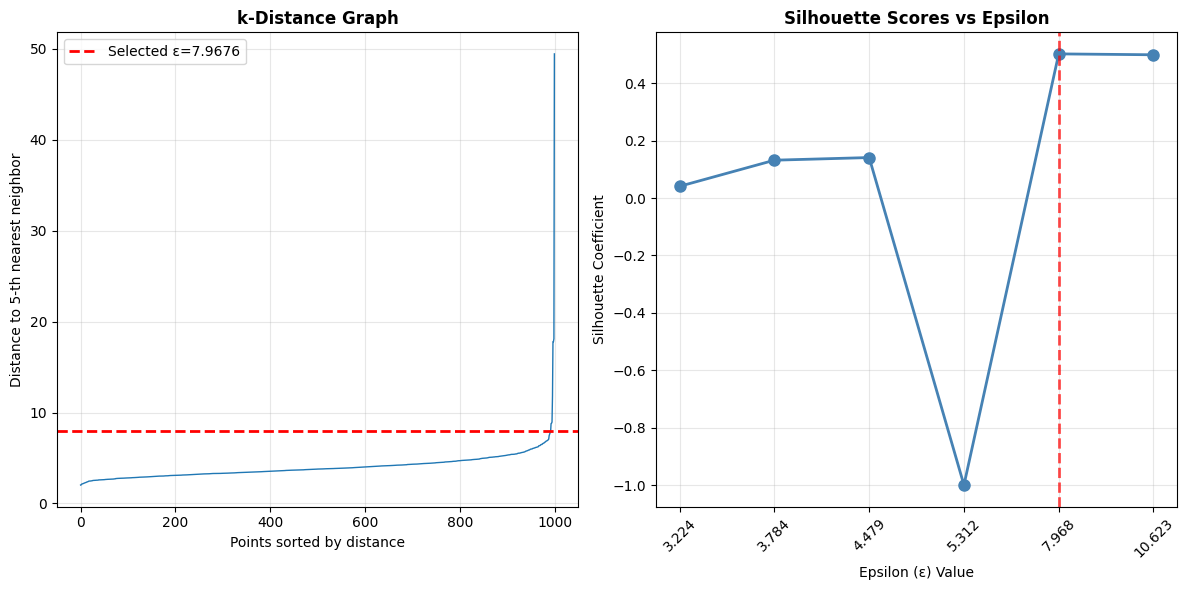

In [9]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.plot(k_distances, linewidth=1)
plt.axhline(y=best_eps, color='red', linestyle='--', linewidth=2, label=f'Selected ε={best_eps:.4f}')
plt.title("k-Distance Graph", fontsize=12, fontweight='bold')
plt.xlabel("Points sorted by distance", fontsize=10)
plt.ylabel(f"Distance to {minPts}-th nearest neighbor", fontsize=10)
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
eps_labels = [f"{eps:.3f}" for eps in eps_values]
plt.plot(range(len(eps_values)), silhouettes, "o-", color = "steelblue", linewidth=2, markersize=8)
if best_eps is not None:
    best_idx = eps_values.index(best_eps)
    plt.axvline(x=best_idx, color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.xticks(range(len(eps_values)), eps_labels, rotation=45)
plt.title("Silhouette Scores vs Epsilon", fontsize=12, fontweight='bold')
plt.xlabel("Epsilon (ε) Value", fontsize=10)
plt.ylabel("Silhouette Coefficient", fontsize=10)
plt.grid(alpha = 0.3)

plt.tight_layout()
plt.show()

## 2D Visualization of Clusters 

For visualization, we plot the 50-dim PCA data into a 2D scatter plot. 

*Different colour = different cluster.*

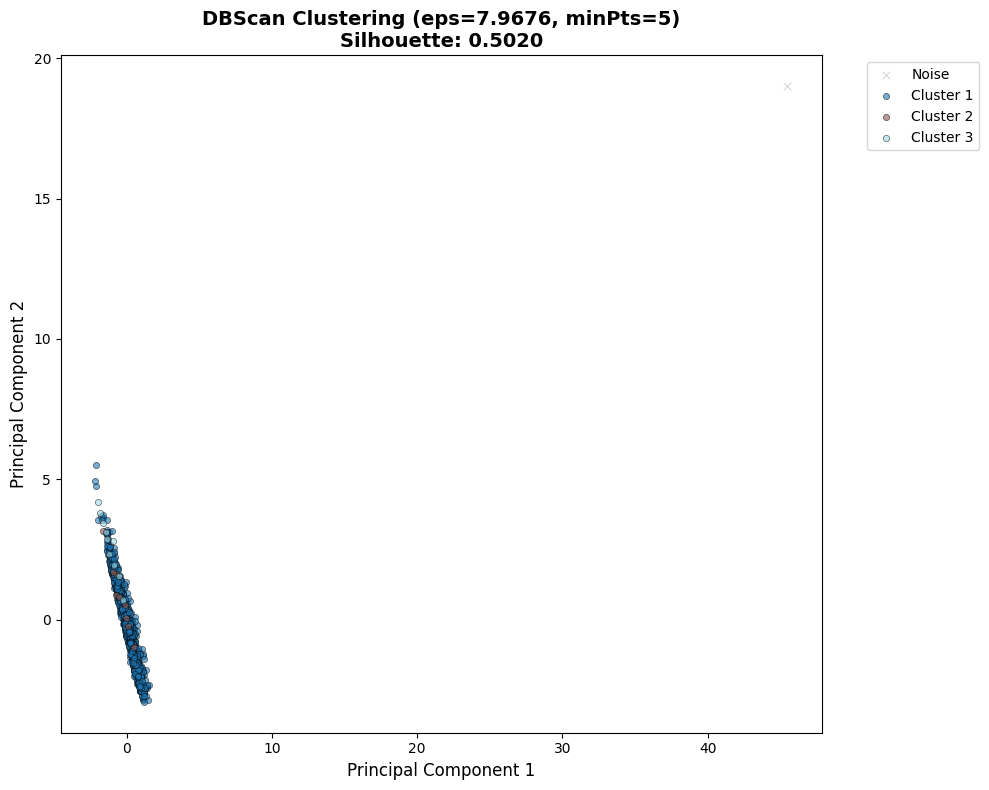

In [10]:
X_vis = PCA(n_components = 2).fit_transform(X)
cmap = matplotlib.colormaps["tab20"]
unique_clusters = np.unique(best_clustering)
num_clusters = len(unique_clusters)

plt.figure(figsize = (10, 8))

# Plot noise points first (if any)
if 0 in unique_clusters:
    noise_mask = best_clustering == 0
    plt.scatter(X_vis[noise_mask, 0], X_vis[noise_mask, 1],
                s = 30, alpha = 0.5, color = "gray", 
                marker = "x", linewidths = 0.5, label = "Noise")

# Plot actual clusters (excluding noise)
cluster_ids = [cid for cid in unique_clusters if cid != 0]
for i, cid in enumerate(cluster_ids):
    mask = best_clustering == cid
    c_value = i / max(len(cluster_ids) - 1, 1) if len(cluster_ids) > 1 else 0
    color = cmap(c_value)
    plt.scatter(X_vis[mask, 0], X_vis[mask, 1],
        s = 20, alpha = 0.6, color = color, edgecolors = "black",
        linewidths = 0.5, label = f"Cluster {int(cid)}")

# Add silhouette score to title
title = f"DBScan Clustering (eps={best_eps:.4f}, minPts={minPts})"
if best_score > -1:
    title += f"\nSilhouette: {best_score:.4f}"

plt.title(title, fontsize = 14, fontweight = "bold")
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left")
plt.tight_layout()
plt.show()

# **Interpretation & Discussion**
## **Strengths of DBScan Clustering**

* Does not require initialization of centroids and/or clusters
* Robust to noise/outliers in dataset 
* Reveals correlation between features in the same cluster due to objects in cluster being density-reachable

---

## **Problems of DBScan Clustering**

* Running time at worst case (choice of epsilon, minPts, noise/cluster separation) is **O(n2)** → requires representative subset of dataset
* As with hierarchical clustering, results are dependent on euclidean distance of points after PCA dimensionality reduction. 
* Difficulty in separating noise from clusters and may negatively impact results
* Varying density in the dataset may result in inaccurate clustering. 
